# *eht-imaging* tutorial #1

---

`eht-imaging` is a Python software for radio interferometric simulation, calibration, analysis, and imaging. 

Code and documentation can be found on [GitHub](https://github.com/achael/eht-imaging)

This notebook is an initial eht-imaging tutorial introducing data preparation, simulation, and Stokes I imaging. 

## Prerequisites
Running this notebook requires that `eht-imaging` and its dependencies are installed (see README on [GitHub](https://github.com/achael/eht-imaging)). If you do not have `nfft` installed, you can set `ttype=direct` or `ttype=fast` in the following.

In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import ehtim as eh
from   ehtim.calibrating import self_cal as sc
import time

plt.close('all')

# Fourier transform type - change this to 'direct' if 'nfft' is not installed!!!
ttype = 'nfft'

Welcome to eht-imaging! v 1.2.8 



## Load Image

In [2]:
# Load the image and the telescope array
im = eh.image.load_image('../models/rowan_m87.txt')
eht = eh.array.load_txt('../arrays/EHT2017.txt')

Loading text image:  ../models/rowan_m87.txt


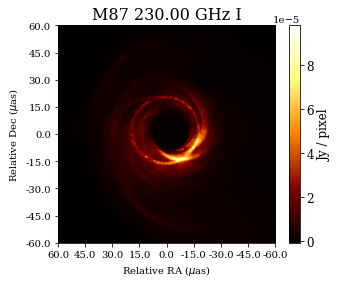

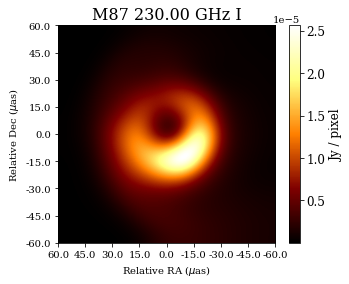

In [4]:
# Regrid the image for display
imdisp = im.regrid_image(120*eh.RADPERUAS, 512)
# Look at the image
imdisp.display();
imdisp.blur_circ(15*eh.RADPERUAS).display();

## Simulate an observation and plot data

In [5]:
# simulate and save an EHT observation
# ampcal and phasecal determine if gain variations and phase errors are included
# for now, let's assume we can calibrate both amplitude and phase
# try changing phasecal=False and see what happens!

# simulation parameters
tint_sec = 60  # Integration time in seconds, 
tadv_sec = 600 # Advance time between scans
tstart_hr = 0  # GMST time of the start of the observation
tstop_hr = 24  # GMST time of the end of the observation
bw_hz = 4.e9   # Bandwidth in Hz

# generate the observation
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=True)

# save the observation in a uvfits files 
obs.save_uvfits('./tutorial_results/ehtim_tutorial1.uvfits')

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Building NX table


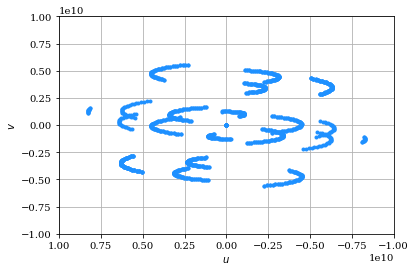

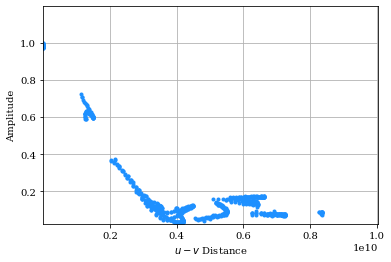

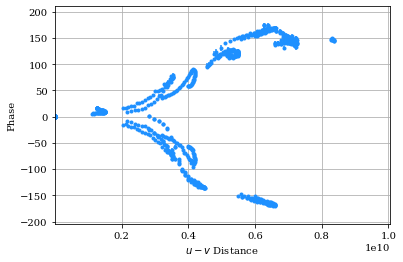

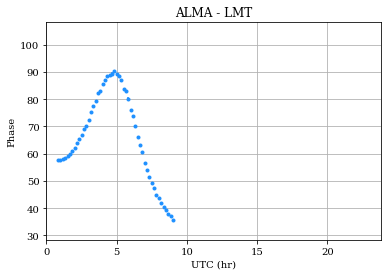

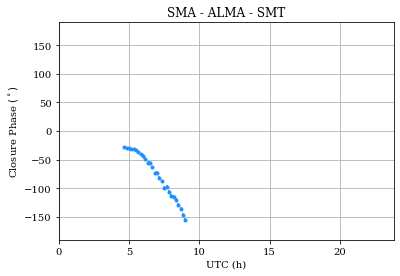

In [6]:
# Plot uv coverage
obs.plotall('u','v', conj=True, rangex=[1.e10,-1.e10],rangey=[-1.e10,1.e10]) 

# Plot amplitude with baseline distance
obs.plotall('uvdist','amp')  

# Plot phase with baseline distance'
obs.plotall('uvdist','phase') 

# Plot visibility phase on a baseline over time 
obs.plot_bl('ALMA','LMT','phase') 

# Plot closure phase on a triangle over time
obs.plot_cphase('SMA','ALMA','SMT'); 

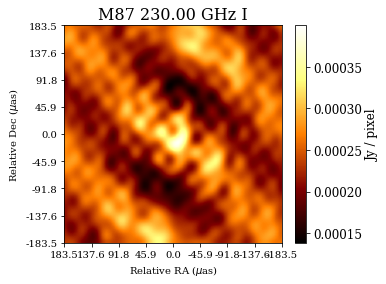

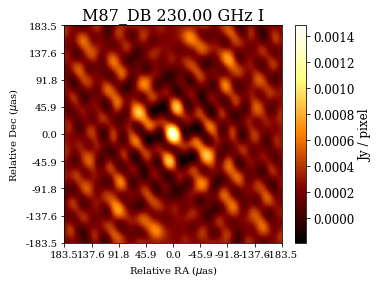

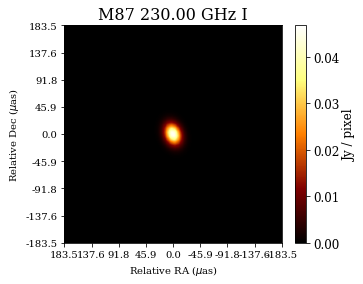

In [7]:
# Plot the dirty image, dirty beam, and clean beam
npix = 64
fov = im.xdim * im.psize

# dirty image
dim = obs.dirtyimage(npix, fov)
dim.display();

# dirty beam
dbeam = obs.dirtybeam(npix, fov)
dbeam.display();

# clean beam
cbeam = obs.cleanbeam(npix,fov)
cbeam.display();

In [8]:
# What is the resolution of the observation? 
beamparams = obs.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res = obs.res()             # nominal array resolution, 1/longest baseline


print("Clean beam parameters: [%.1f uas,%.1f uas,%.1f deg]"
      %(beamparams[0]/eh.RADPERUAS, beamparams[1]/eh.RADPERUAS,beamparams[2]/eh.DEGREE))
print("Nominal Resolution: %.1f uas"%(res/eh.RADPERUAS))

Clean beam parameters: [28.5 uas,20.4 uas,20.0 deg]
Nominal Resolution: 24.7 uas


## Set  Up and Run an Imager with Complex Visibilities

In [9]:
# Image Parameters
npix = 100
fov = 200*eh.RADPERUAS
zbl = im.total_flux() # total flux

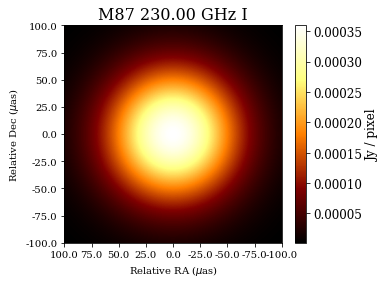

In [10]:
# Set up and display an image prior
prior_fwhm = 100*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
gaussprior.display();

In [11]:
# Image total flux with amplitude and closure phase
data_term={'vis':1}              # data term weights
#reg_term = {'tv2':1, 'l1':0.1}   # regularizer term weights
reg_term = {'tv2':1, 'simple':0.1, 'l1':0.1}   # regularizer term weights
reg_term = {'tv2':1, 'l1':0.1}   # regularizer term weights


# set up the imager
imgr  = eh.imager.Imager(obs, gaussprior, prior_im=gaussprior, flux=zbl,
                         data_term=data_term, reg_term=reg_term, 
                         norm_reg=True, # this is very important!
                         epsilon_tv = 1.e-10,
                         maxit=250, ttype=ttype)

Initializing imager data products . . .


In [12]:
# run the imager
# NOTE: show_updates does not display well in jupyter for some reason
# try using show_updates in a terminal window
# but here we keep show_updates=False for speed
imgr.make_image_I(show_updates=False)

Imager run 1 
Imaging . . .
time: 1.522658 s
J: 1.887431
chi2_vis : 1.74 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


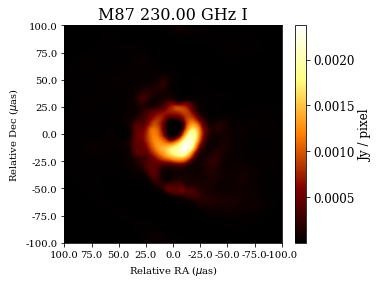

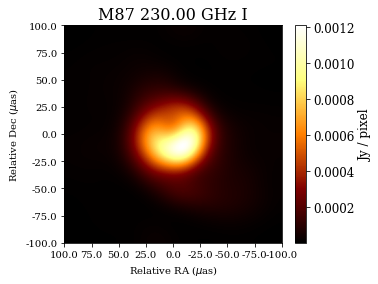

In [13]:
# Display the raw result of the first round
out = imgr.out_last()
out.display()

# Blur the result to the nominal resolution and display
outblur = out.blur_circ(res)
outblur.display();

Imager run 2 
Imaging . . .
time: 1.374972 s
J: 1.620018
chi2_vis : 1.47 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


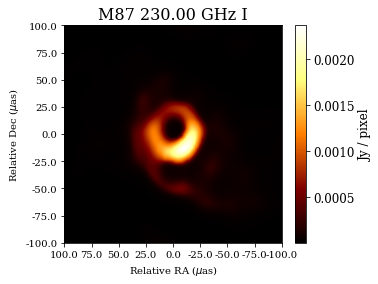

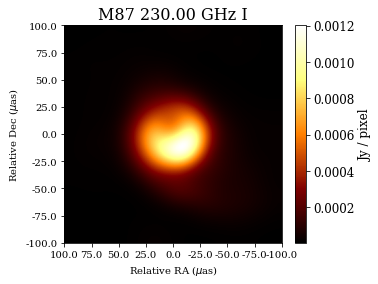

In [14]:
# re-initialize imager with the blurred output of the last round
imgr.init_next = imgr.out_last().blur_circ(res)

# run the imager a second time
imgr.make_image_I(show_updates=False)

# display the output of the second round
out = imgr.out_last()
outblur = out.blur_circ(res)
out.display();
outblur.display();

Imager run 3 
Imaging . . .
time: 2.883602 s
J: 1.160398
chi2_vis : 1.18 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


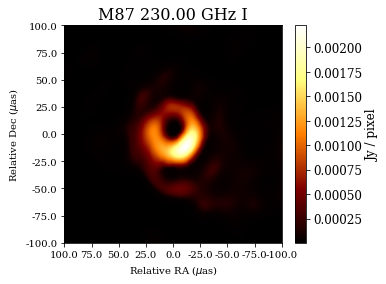

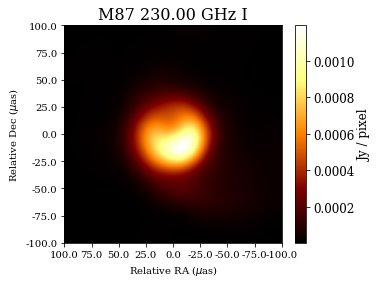

In [15]:
# update the initial image and image one more time
imgr.init_next = imgr.out_last().blur_circ(res) # re-initialze the imager
imgr.maxit_next = 500                           # let the imager run for more iterations this time
imgr.make_image_I(show_updates=False)           # run imager

# display the final output
out = imgr.out_last()
outblur = out.blur_circ(res)
out.display();
outblur.display();

## Set  Up and Run an Imager with Closure Phases and Amplitudes

In [16]:
# Image total flux with closure amplitudes and closure phase
#data_term={'logcamp':1,'cphase':0.5} # data term weights
data_term={'amp':1,'cphase':0.5} # data term weights

#reg_term = {'tv2':1, 'l1':0.1}   # regularizer term weights
reg_term = {'tv2':1, 'l1':0.1}   # regularizer term weights

# set up the imager
imgr  = eh.imager.Imager(obs, gaussprior, prior_im=gaussprior, flux=zbl,
                         data_term=data_term, reg_term=reg_term, 
                         norm_reg=True, # this is very important!
                         epsilon_tv = 1.e-10,
                         maxit=250, ttype=ttype)

# image the first time
imgr.make_image_I(show_updates=False)

# re-initialize and image again
imgr.init_next = imgr.out_last().blur_circ(res)
imgr.make_image_I(show_updates=False)

# image one last time
imgr.init_next = imgr.out_last().blur_circ(res) 
imgr.maxit_next = 500                          
imgr.make_image_I(show_updates=False)           


Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 2.603432 s
J: 2.460339
chi2_amp : 1.63 chi2_cphase : 1.31 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 2.793658 s
J: 1.435775
chi2_amp : 1.20 chi2_cphase : 1.05 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 9.290221 s
J: 1.055099
chi2_amp : 1.05 chi2_cphase : 1.00 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


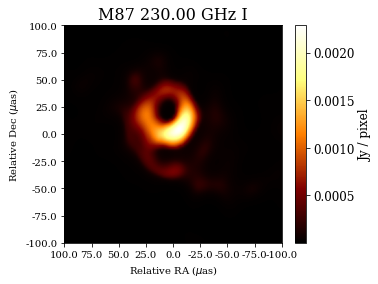

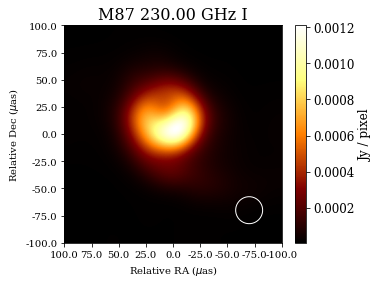

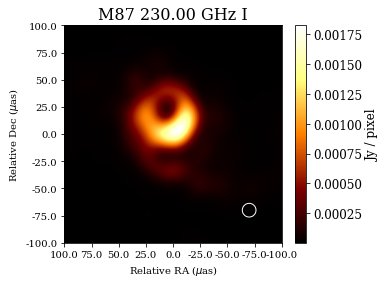

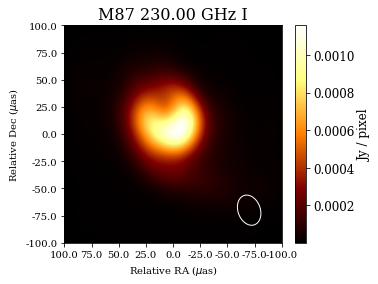

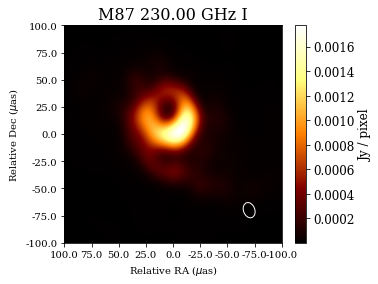

In [17]:
# display the final output at various blur levels
# raw output
out = imgr.out_last()
out.display();

# blurred to the full nominal resolution
outblur1 = out.blur_circ(res) 
outblur1.display(beamparams=[res,res,0]);

# blurred to half the nominal resolution
outblur2 = out.blur_circ(0.5*res) 
outblur2.display(beamparams=[0.5*res,0.5*res,0]);

# blurred to  the asymmetric nominal beam
outblur3 = out.blur_gauss(beamparams) 
outblur3.display(beamparams=beamparams);

# blurred to half the asymmetric nominal beam
beamparams_superres=[0.5*beamparams[0],0.5*beamparams[1],beamparams[2]]
outblur3 = out.blur_gauss(beamparams_superres) 
outblur3.display(beamparams=beamparams_superres);

In [18]:
# save the output
out.save_fits('./tutorial_results/ehtim_tutorial1_output.fits')